In [659]:
import pandas as pd
import numpy as np
import pvlib
from pvlib.location import Location
import sympy as sm
import matplotlib.dates as mdates

from scipy import integrate

def inner(x1: sm.Matrix,x2: sm.Matrix):
    '''
    Computes the inner product of two vectors of same length.
    '''

    return x1.dot(x2, conjugate_convention = 'right')

#generation of date strings for all dates in year 2024
dateList= []
daysInMonth=[31,29,31,30,31,30,31,31,30,31,30,31]
#create list of all days
for i in range (12): #months
    for j in range (1,daysInMonth[i]+1):
        date = "2024-"
        date=date+"0"+str(i+1)+"-" if i+1<10 else date+str(i+1)+"-"#add month
        date = date +"0"+str(j) if (j<10) else date+str(j)        
        dateList.append(date)

sm.MutableDenseMatrix.inner = inner
sm.ImmutableDenseMatrix.inner = inner
L = 1.755
B = 1.038
maxFlux = 1000
maxEffect = 365/(L*B)
A = 0.5
S0 = 1100
S0A = S0 * A
effectPerFlux = maxEffect/maxFlux

In [660]:
def solar_elevation_angledeg(angle):
    return 90-angle

## Funktion til liste af værdier i interval

In [661]:
def inInterval(list,min,max):
    out = list[list>min]
    out = out[out<max]
    return out

## Funktion til index i interval

In [662]:
def IndexInInterval(list,lower,upper):
    list= np.array(list)
    t=np.arange(len(list))
    t=t[list[t]>=lower]
    t=t[list[t]<=upper]
    return t
    

## Bestemmelse af nulpunkter

In [663]:
#return i, where list[i] has one sign, list[i+1] has another
def signChange(list): #return index in list
    signList=np.sign(list)
    diffList=np.diff(signList)
    switch=np.where(diffList != 0, 1,0)   
    indices = np.arange(len(switch))
    indices = indices[switch==1]
    
    return indices
def signChangeFunc(inputParameter, list): #return input value
    signList=np.sign(list)
    diffList=np.diff(signList)
    switch=np.where(diffList != 0, 1,0)   
    indices = np.arange(len(switch))
    indices = indices[switch==1]
    return inputParameter[indices]

testArray =np.array([3, 0.5, 0.1,-0.5, -1, -0.5, 0.5, 2])

display(signChange(testArray))
#note zero indexing

array([2, 5])

In [664]:
#test on function
t = np.linspace(0, 2 * np.pi, 1000)
f = np.cos(t)
display(t[signChange(f)])
display(signChangeFunc(t,f))

list = t[signChange(f)]
for i in list:
    display(i/np.pi * sm.symbols('pi'))
    


array([1.56607922, 4.71081661])

array([1.56607922, 4.71081661])

0.498498498498498*pi

1.4994994994995*pi

Som kan ses, er det $\frac{\pi}{2}$ og $\frac{3\cdot \pi}{2}$, som passer med cosinus

## Sfæriske koordinater til kartesiske

In [665]:
# takes list of zenith, and azimuth angles, in radians and distance in meters
def angleToKar(zenith, azimuth, d):
    zenith= np.array(zenith)
    azimuth= np.array(azimuth)
    d =  np.array(d)
    index = np.arange(len(zenith))  #list of indexes in angle lists
    x_results = d[index]*np.sin(zenith[index])*np.cos(azimuth[index]) #generate list of all x-coordinates
    y_results = d[index]*np.sin(zenith[index])*np.sin(azimuth[index]) #generate list of all y-coordinates
    z_results = d[index]*np.cos(zenith[index])                        #generate list of all z-coordinates
    if(len(x_results)==1): #if only one input, return vector
        return np.array([x_results[0],y_results[0],z_results[0]])
    else: 
        results=[]
        for i in range (len(x_results)): 
           results.append(np.array([x_results[i],y_results[i],z_results[i]])) #set of x,y,z coordinates
        return results

#test
list=angleToKar([0,np.pi/2,np.pi,np.pi/2],[np.pi/2,0,np.pi,np.pi],[1,1,1,1])
display(list)
expectedList=[[0,0,1],[1,0,0],[0,0,-1],[-1,0,0]]
for i in range (len(list)):
    for j in range (len(list[i])):
        print (np.allclose(list[i][j],expectedList[i][j],0.0001,0.0001)) #
    

[array([0., 0., 1.]),
 array([1.000000e+00, 0.000000e+00, 6.123234e-17]),
 array([-1.22464680e-16,  1.49975978e-32, -1.00000000e+00]),
 array([-1.0000000e+00,  1.2246468e-16,  6.1232340e-17])]

True
True
True
True
True
True
True
True
True
True
True
True


## Kartesiske koordinater til sfæriske


In [666]:
def karToAngle(coordinates,d): #takes list of zenith, and azimuth angles, in radians and distance in meters
    theta_s = np.rad2deg(np.arccos((coordinates[2])/(d))) 
    if (theta_s==0): #phi_s can be any angle in this scenario.
        return([0,0])
    else:
        phi_s= np.rad2deg(np.arccos((coordinates[0])/(((d) * np.sin(theta_s))))) 
        if  np.isnan(phi_s):
            phi_s = np.rad2deg(
                np.arcsin((coordinates[1])/(((d) * np.sin(theta_s)))))


        return np.array([theta_s,phi_s])
    
testList = [0,0,1]#,[0,0],[np.pi/2,np.pi/2]]
karToAngle(testList,1)

[0, 0]

## Metoder


In [667]:
def solar_panel_projection(θ_s, ϕ_s, θ_p, ϕ_p):
    results = np.zeros(len(θ_s))
    for i in range(0,len(θ_s)):
        us = [-np.sin(θ_s[i]) * np.cos(ϕ_s[i]),-np.sin(θ_s[i]) * np.sin(ϕ_s[i]), -np.cos(θ_s[i])]
        up = [-np.sin(θ_p[i]) * np.cos(ϕ_p[i]), -np.sin(ϕ_p[i])*np.sin(θ_p[i]), -np.cos(θ_p[i])]
        inprod = (np.inner(us,up))
        results[i]=inprod
    results=results[results>0]
    return results



In [668]:

def kWhHour(zenithangs,azimuthangs, theta_p, phi_p):
    indexOfInterest=IndexInInterval(zenithangs,0,np.pi/2)
    zenithangs=zenithangs[indexOfInterest]
    azimuthangs=azimuthangs[indexOfInterest]
    
    theta_list= np.full(len(zenithangs),theta_p)
    phi_list=np.full(len(zenithangs),phi_p)
    
    projList =  solar_panel_projection(zenithangs,azimuthangs,theta_list,phi_list)
    projList =  projList*effectPerFlux*S0A
    projList[projList>maxEffect]=maxEffect    
    return ((integrate.simpson(projList,dx = 3600))*L*B)/3600000

def kWhMin(zenithangs,azimuthangs, theta_p, phi_p):
    indexOfInterest=IndexInInterval(zenithangs,0,np.pi/2)
    zenithangs=zenithangs[indexOfInterest]
    azimuthangs=azimuthangs[indexOfInterest]
    
    theta_list= np.full(len(zenithangs),theta_p)
    phi_list=np.full(len(zenithangs),phi_p)
    
    projList =  solar_panel_projection(zenithangs,azimuthangs,theta_list,phi_list)
    projList =  projList*effectPerFlux*S0A
    projList[projList>maxEffect]=maxEffect    
    return ((integrate.simpson(projList,dx = 60))*L*B)/3600000




# Flux hver minut for en dag

In [669]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-04-01"
slut_dato = "2024-04-30"
delta_tid = "Min"  # "Min", "H",
S0=1100 #irradiance
A=0.5 #reduction
valgt_dato = "2024-04-20"

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.7861111111, 12.5230555556, tidszone, 10, "DTU (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

results = []
zenithangs = np.deg2rad(np.array(solpos.loc[valgt_dato].apparent_zenith))
azimuthangs = np.deg2rad(np.array(solpos.loc[valgt_dato].azimuth))

def FluxForEachMinute(zenithAngs, azimuthAngs, theta_p, phi_p):
    t = np.arange(len(zenithangs))
    indexOfInterest = t[zenithangs[t] > 0]
    indexOfInterest = indexOfInterest[zenithangs[indexOfInterest] < np.pi/2]
    zenithangs = zenithangs[indexOfInterest]
    azimuthangs = azimuthangs[indexOfInterest]
    theta_list = np.full(len(zenithangs), theta_p)
    phi_list = np.full(len(zenithangs), phi_p)
    projList = solar_panel_projection(
        zenithangs, azimuthangs, theta_list, phi_list) * S0*A
    return projList

## For én dag (20. April 2024)

In [670]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-04-01"
slut_dato = "2024-04-30"
delta_tid = "Min"  # "Min", "H",

valgt_dato = "2024-04-20"

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.7861111111, 12.5230555556, tidszone, 10, "DTU (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

In [671]:
results = []
zenithangs = np.deg2rad(np.array(solpos.loc[valgt_dato].apparent_zenith))
azimuthangs = np.deg2rad(np.array(solpos.loc[valgt_dato].azimuth))
# Azimuth vinkel for panelet
phi_p = 180

#Der itereres over panelets zenith vinkler fra 0 til 90
for i in range(0,91):
    theta_p = i
 # Effekten for dag ved en given zenith vinkel for panelet beregnes
    energy = kWhMin(zenithangs,azimuthangs, np.deg2rad(theta_p), np.deg2rad(phi_p))
    results.append(energy)
# Finder maks effekt og tilsvarende vinkel

max = 0
angle = -1
for i in range(0,len(results)):
    print(results[i])
    if(results[i] > max):
        max = results[i]
        angle = i
print("Energy Production is:",max,
"Angle is:",solar_elevation_angledeg(angle),"Degrees from horizon",)

display()

1.2933367807002514
1.3078597165295913
1.3221265224093355
1.3361153083467254
1.3498063858409348
1.3631859738264187
1.37624151177084
1.3889657490668754
1.4013415498304207
1.4133671769605274
1.4250298694354655
1.436327386297881
1.4472485316819252
1.4577806106719846
1.4679250630099416
1.477676794166191
1.4870185416643003
1.495966930729994
1.5044945505337342
1.512610728829934
1.5203094776873696
1.527570714521443
1.5344195981910154
1.540835447636449
1.5468154706988038
1.552357027114309
1.5574529185210249
1.562106984057799
1.5663213412827046
1.5700877310652752
1.573404307800423
1.5762693855480634
1.5786814390997448
1.5806391049336357
1.5821411820568654
1.5831866328776778
1.5837745839118833
1.5839043265134851
1.5835753174431404
1.5827871794608268
1.5815397017545527
1.5798410085830634
1.5776763973251675
1.5750529387998802
1.5719784040220566
1.5684404036683455
1.564445503389882
1.5599946459686453
1.5550889418069171
1.5497386818733405
1.5439294799504828
1.5376698170440857
1.5309698647930454
1.523

## For et år

In [672]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "H" # "Min", "H",
# Definition of Location object. Coordinates and elevation of DTU, Copenhagen (Denmark)
site = Location(
55.7861111111, 12.5230555556, tidszone, 10, "DTU (DK)"
) # latitude, longitude, time_zone, altitude, name
# Definition of a time range of simulation
times = pd.date_range(
start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)
# Estimate Solar Position with the ’Location’ object
solpos = site.get_solarposition(times)
results = []
#Lister af solens Zenith og Azimuth vinkler hver time over et  ̊ar
zenithangs = np.deg2rad(np.array(solpos.loc[start_dato:slut_dato].apparent_zenith))
azimuthangs = np.deg2rad(np.array(solpos.loc[start_dato:slut_dato].azimuth))
# Azimuth vinkel for panelet
phi_p = 180

#Der itereres over panelets zenith vinkler fra 0 til 90

for i in range(0,91):
    theta_p = i 
 # Effekten for et helt  ̊ar ved en given zenith vinkel for panelet beregnes
    energyPrYear = kWhHour(zenithangs,azimuthangs, np.deg2rad(theta_p), np.deg2rad(phi_p))
    results.append(energyPrYear)
# Finder maks effekt og tilsvarende vinkel
max = 0
angle=-1
for i in range(0,len(results)):
    print(results[i])
    if(results[i] > max):
        max = results[i]
        angle= i 
print("Energy Production is:",max,
"Angle is:",solar_elevation_angledeg(angle),"Degrees from horizon", "and ", angle, "from vertical")

337.82509064147666
343.9330808487314
349.9711957781455
356.01884514713254
362.0814168437266
367.713956531926
373.4153921310897
379.3444834483196
384.86261077504065
390.8097099572764
396.3456123325702
401.582389325118
407.0936468549035
412.03208601099635
417.1598671044049
422.0658863731435
427.09547167788566
431.6287771539241
436.4366250739413
440.6867779680704
444.9277317377383
449.1041798769369
454.08362293503274
458.0010628310881
461.2980987144679
465.64989369511517
468.9190056823618
472.9111639615116
475.8843683563681
479.33509444279645
482.20191675657384
485.46750479620795
488.1772319136651
491.0858866918508
493.6776700461101
495.9077237651038
498.41322365700717
500.2955762686786
502.2566087564733
504.05486789269486
506.14077311321427
507.1871837404174
508.5281117342876
510.4087423427366
511.5363891686873
512.5080410672047
513.3443006388034
513.1169686342614
513.607642476924
515.0018328794681
515.2865388563033
515.4743849494683
515.5818962388123
515.3885514407692
515.0382142972761


## Parcel hus

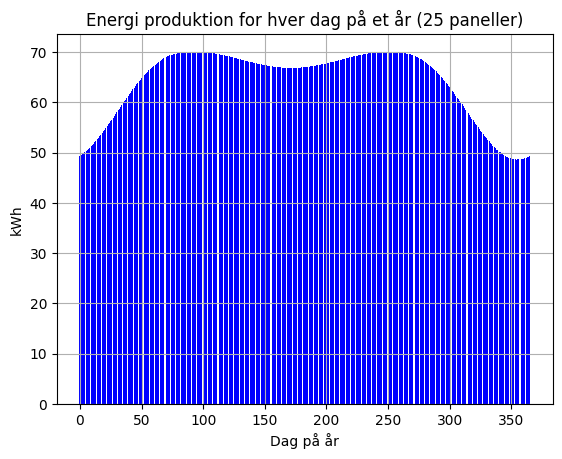

In [673]:
amount = 25
L = 1.755
B = 1.038
Area = L * B * amount # 25 paneler
maxFlux = 1000
maxEffect = 365
A = 0.5
S0 = 1100
S0A = S0 * A
effectPerFlux = maxEffect/maxFlux

theta_p=52
phi_p=180


tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.7861111111, 12.5230555556, tidszone, 10, "DTU (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)




energyDayList=[] 
for i in range(len(dateList)):
    zenithAngs = np.deg2rad(np.array(solpos.loc[dateList[i]].apparent_zenith))
    azimuthAngs =np.deg2rad(np.array(solpos.loc[dateList[i]].azimuth))
    energyDayList.append(25*kWhMin(zenithAngs,azimuthAngs, np.deg2rad(theta_p), np.deg2rad(phi_p)))
    

x_pos = np.arange(366)
np.delete(x_pos,0)

import matplotlib.pyplot as plt

%matplotlib inline
plt.bar(x_pos,energyDayList,
        color='b',
        #width=1, 
        
        #edgecolor='b',
        #linewidth=0.5,
        )
plt.title('Energi produktion for hver dag på et år (25 paneller)')
plt.xlabel('Dag på år')
plt.ylabel('kWh')
plt.grid(axis='y')
plt.grid(axis='x')

Optimal $\phi$ og $\theta$ combo

In [674]:
#tidszone = "Europe/Copenhagen"
#start_dato = "2024-01-01"
#slut_dato = "2024-12-31"
#delta_tid = "H"  # "Min", "H",
## Definition of Location object. Coordinates and elevation of DTU, Copenhagen (Denmark)
#site = Location(
#    55.7861111111, 12.5230555556, tidszone, 10, "DTU (DK)"
#)  # latitude, longitude, time_zone, altitude, name
## Definition of a time range of simulation
#times = pd.date_range(
#    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
#)
## Estimate Solar Position with the ’Location’ object
#solpos = site.get_solarposition(times)
#results = []
## Lister af solens Zenith og Azimuth vinkler hver time over et  ̊ar
#zenithangs = np.deg2rad(
#    np.array(solpos.loc[start_dato:slut_dato].apparent_zenith))
#azimuthangs = np.deg2rad(np.array(solpos.loc[start_dato:slut_dato].azimuth))
## Azimuth vinkel for panelet
#phi_p = 180
#
## Der itereres over panelets zenith vinkler fra 0 til 90
#for p in range(0, 360):
#    phi_p = p
#    for i in range(0, 91):
#        theta_p = i
#     # Effekten for et helt  ̊ar ved en given zenith vinkel for panelet beregnes
#        energyPrYear = kWhHour(zenithangs, azimuthangs,
#                               np.deg2rad(theta_p), np.deg2rad(phi_p))
#        results.append(energyPrYear)
#    # Finder maks effekt og tilsvarende vinkel
#max = 0
#angle_p = -1
#angle_t = -1
#t= np.arange(len(results))
#list=np.where(results[t]==results.max(),1,0)
#angle_p=t[list[t]==1][0]//90
#angle_t=t[list[t]==1][0]%360
#print("Energy Production is:", max,
#"Angle is:", solar_elevation_angledeg(angle_t),"Degrees from horizon and phi",angle_p)

## Krum overflade



In [675]:
from sympy import *
x, y ,z ,n, u, v, θ, p = symbols('x,y,z,n,u,v,θ,\phi',real=true)

In [676]:
andengrads_a = -0.26/(1.68**2/2**2)

In [677]:
r = Matrix([[u], [v], [andengrads_a*v**2 + 0.26]])
r_u = r.diff(u)
r_v = r.diff(v)
display(r_u)
display(r_v)
product = r_v.cross(r_u)
product

Matrix([
[1],
[0],
[0]])

Matrix([
[                   0],
[                   1],
[-0.736961451247166*v]])

Matrix([
[                   0],
[-0.736961451247166*v],
[                  -1]])

In [678]:
r_jacc = r.jacobian([u, v])
display("jacobian matrix",r_jacc)
r_jacc_alt = sqrt(det(r_jacc.T * r_jacc))
display("area corrigation factor", r_jacc_alt)
V_s = Matrix([[-sin(θ)*cos(p)], [-sin(θ)*sin(p)], [-cos(θ)]])
inner = inner(V_s, product.normalized())
display("inner product <sun,normal>",inner)

in_func = inner*r_jacc_alt
display("function in integral",in_func)



'jacobian matrix'

Matrix([
[1,                    0],
[0,                    1],
[0, -0.736961451247166*v]])

'area corrigation factor'

sqrt(0.543112180624329*v**2 + 1)

'inner product <sun,normal>'

0.736961451247166*v*sin(\phi)*sin(θ)/sqrt(0.543112180624329*v**2 + 1) + cos(θ)/sqrt(0.543112180624329*v**2 + 1)

'function in integral'

sqrt(0.543112180624329*v**2 + 1)*(0.736961451247166*v*sin(\phi)*sin(θ)/sqrt(0.543112180624329*v**2 + 1) + cos(θ)/sqrt(0.543112180624329*v**2 + 1))

In [679]:
integral = integrate(in_func, (v, -1.68/2, 1.68/2), (u, -3.37/2, 3.37/2))

integral

5.6616*cos(θ)

In [680]:
S0 = 1100
A = 0.5

maxEffect = 250
maxEffectPrArea = maxEffect/(0.98*1.8)
maxFlux = 1000
EprF = maxEffectPrArea/maxFlux  # effect per flux
expression = EprF*S0*A * integral
display(expression)

441.309523809524*cos(θ)

In [681]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "H"  # "Min", "H",

valgt_dato = "2024-04-20"

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.7873055556, 12.5270555556, tidszone, 10, "DTU (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:00", inclusive="left", freq=delta_tid, tz=tidszone
)
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

In [682]:
import scipy.integrate as sciInt
zenithAngs = np.deg2rad(
    np.array(solpos.loc[start_dato:slut_dato].apparent_zenith))
azimuthAngs = np.deg2rad(np.array(solpos.loc[start_dato:slut_dato].azimuth))
t= np.arange(len(zenithangs))
indexOfInterest = t[zenithangs[t]>=0]
indexOfInterest = indexOfInterest[zenithangs[indexOfInterest]<=np.pi/2]
zenithangs=zenithangs[indexOfInterest]
azimuthangs=azimuthangs[indexOfInterest]

effectList = np.zeros(len(zenithAngs))


for i in range(len(zenithAngs)):
        effectList[i] = expression.subs({θ: zenithAngs[i], p: azimuthAngs[i]})
        
effectList=effectList[effectList>=0]
effectList[effectList>=maxEffect]=maxEffect

output = (sciInt.simpson(effectList, dx=3600))/3600000

output

671.3145147742283